In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Data Loading and Exploration

print("\nInitial Data Exploration")

try:
    data_raw = pd.read_csv('ocr_prediction_enhanced.csv')
    data_raw['month'] = pd.to_datetime(data_raw['month'])
    print(f"Data loaded successfully")
    print(f"Shape: {data_raw.shape[0]} rows × {data_raw.shape[1]} columns")
    print(f"Date range: {data_raw['month'].min().strftime('%Y-%m')} to {data_raw['month'].max().strftime('%Y-%m')}")
except FileNotFoundError:
    print("Error: Please ensure 'ocr_prediction_enhanced.csv' is in the working directory")
    exit()

# Basic dataset information
print(f"\nDataset Overview:")
print(f"Columns: {list(data_raw.columns)}")
print(f"\nData Types:")
print(data_raw.dtypes)

print(f"\nSummary Statistics:")
print(data_raw.describe())

# Missing values
print(f"\nMissing Values Investigation:")
missing_values = data_raw.isnull().sum()
missing_pct = (missing_values / len(data_raw)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing %': missing_pct
}).round(2)
print(missing_df[missing_df['Missing Count'] > 0])



Initial Data Exploration
Data loaded successfully
Shape: 44 rows × 11 columns
Date range: 2021-06 to 2025-01

Dataset Overview:
Columns: ['month', 'OCR', 'CPI_pct', 'UnemploymentRate', 'CoreInflation', 'HousePriceGrowth', 'TWI', 'FloatingMortgage', 'TermDeposit6M', 'OCR_next', 'OCR_direction']

Data Types:
month               datetime64[ns]
OCR                        float64
CPI_pct                    float64
UnemploymentRate           float64
CoreInflation              float64
HousePriceGrowth           float64
TWI                        float64
FloatingMortgage           float64
TermDeposit6M              float64
OCR_next                   float64
OCR_direction               object
dtype: object

Summary Statistics:
                               month        OCR    CPI_pct  UnemploymentRate  \
count                             44  44.000000  44.000000         44.000000   
mean   2023-03-17 12:32:43.636363520   3.664773   5.227273          3.918939   
min              2021-06-01 00:

**Missing Values**

As expected of data originally from government sources, the data has very few missing values, with only one missing value in the entire dataset. This is very promising considering how small of a sample size the model has to work with for the short span of 5 years of monthly data.


Pre-Processing Data Visualisations


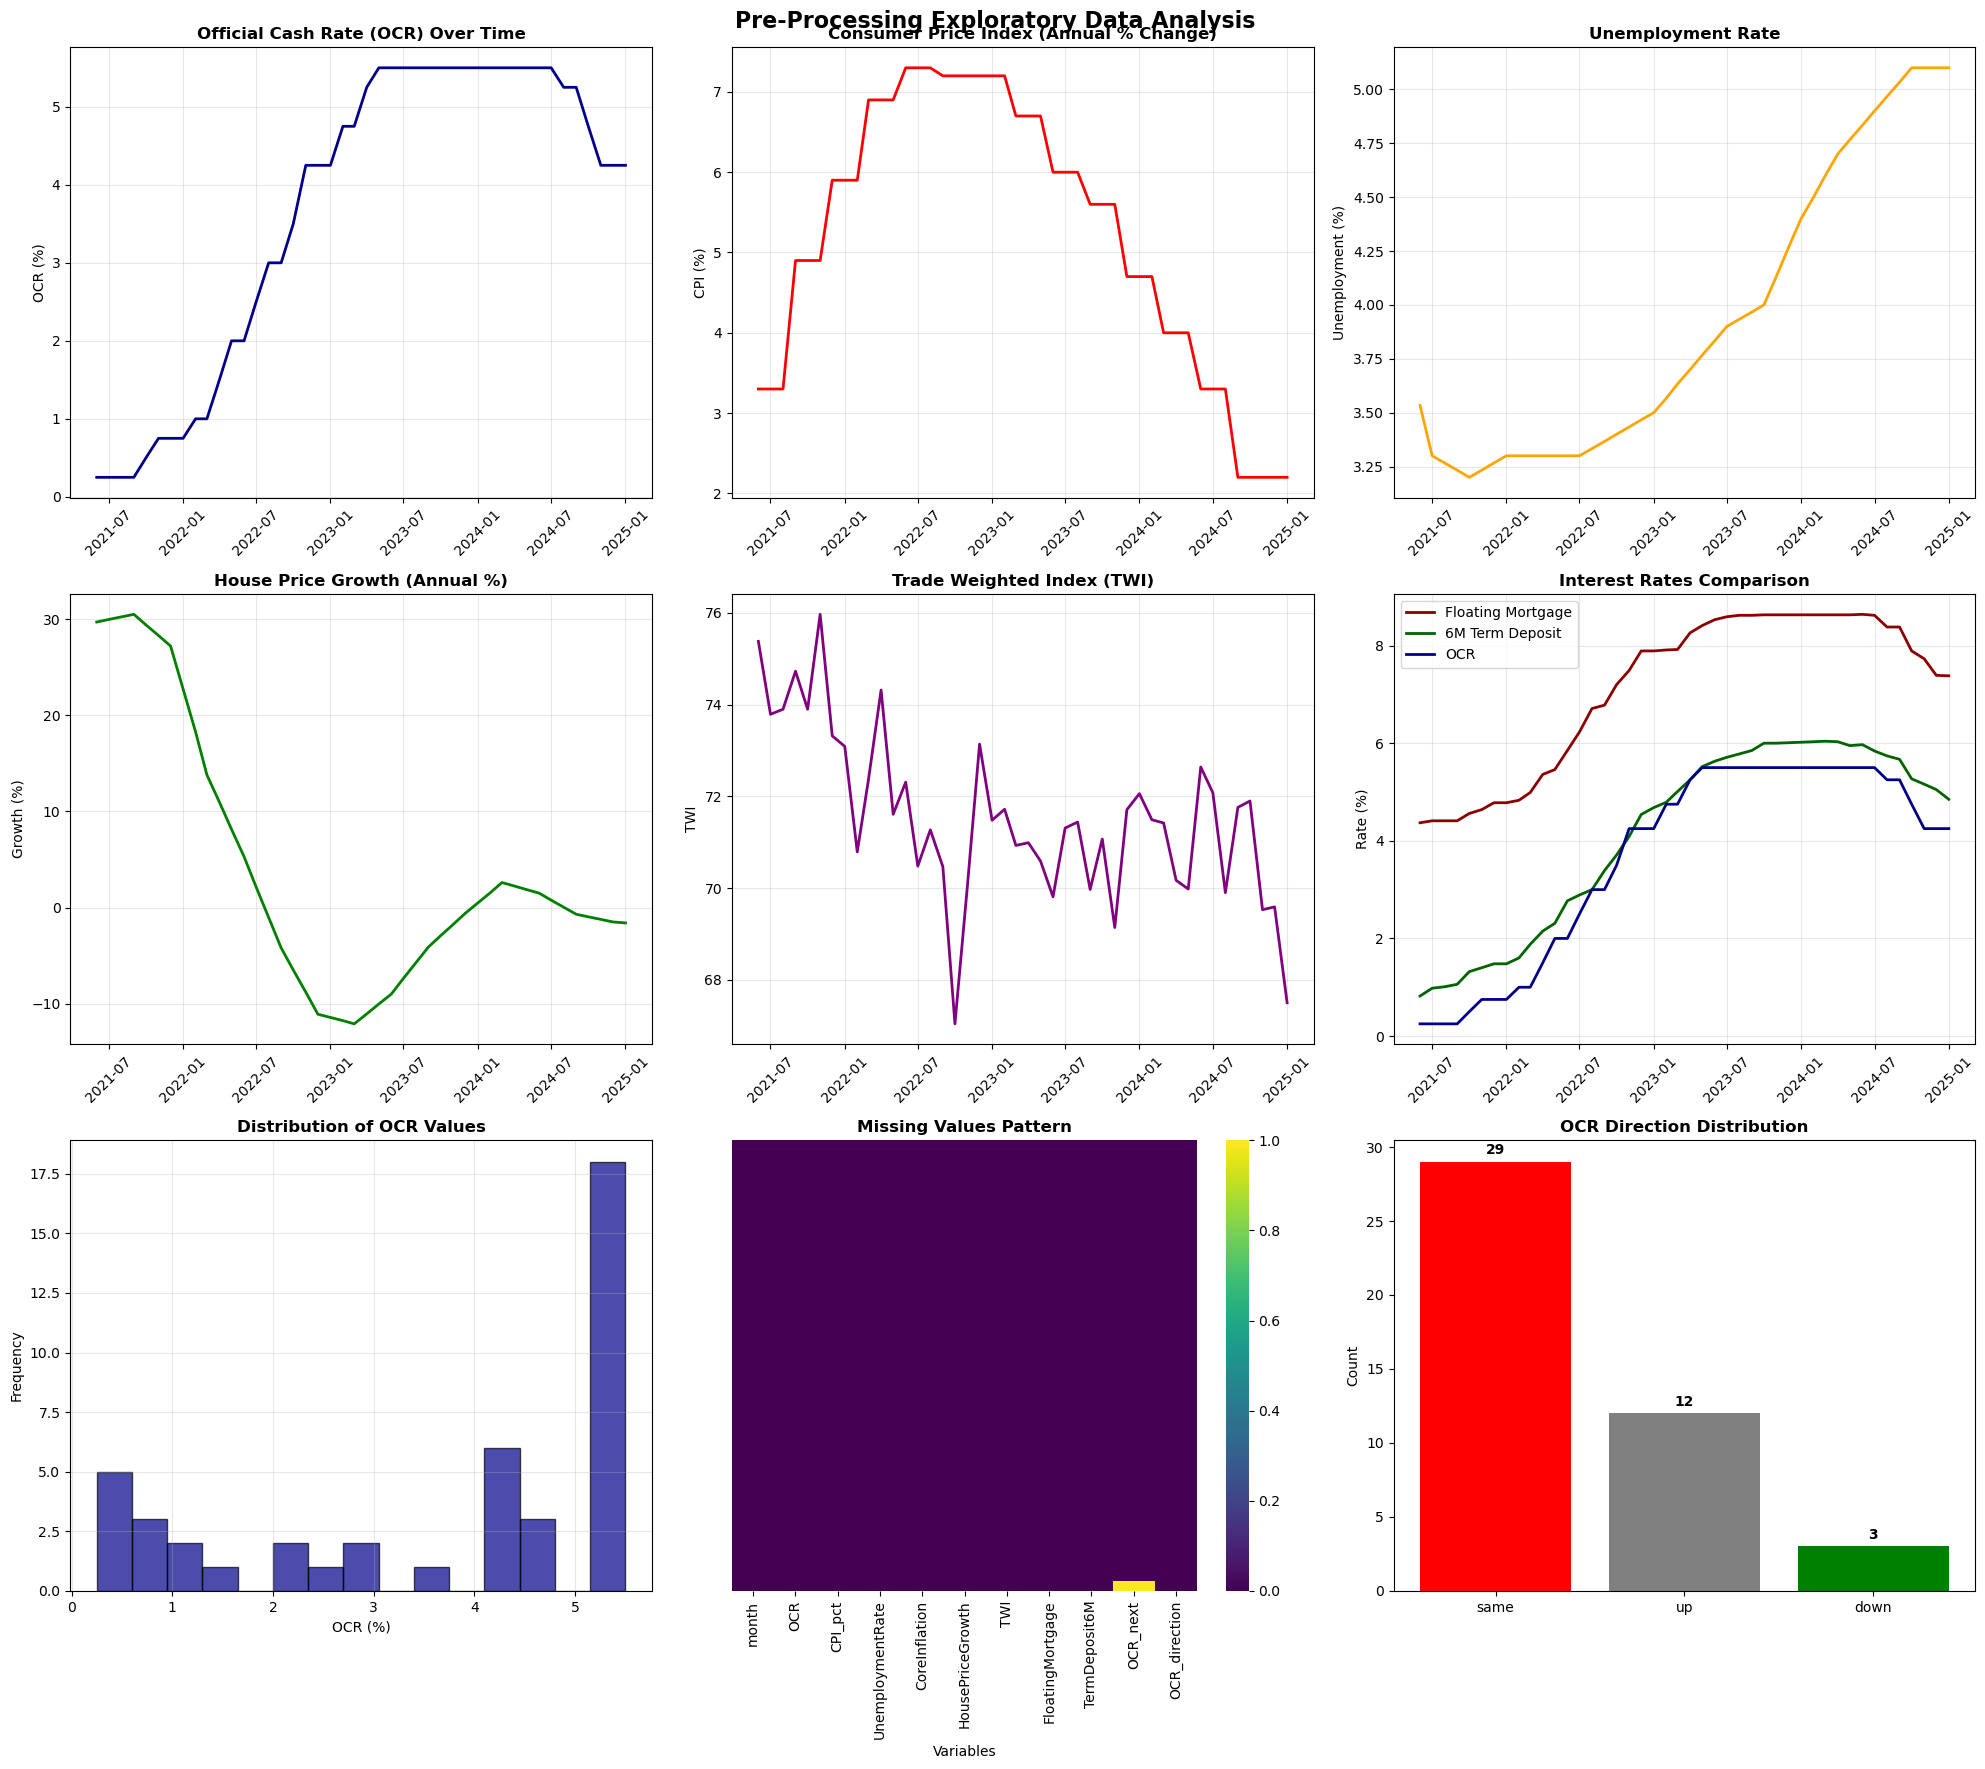

In [67]:
print(f"\nPre-Processing Data Visualisations")

# Create comprehensive EDA plots
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Pre-Processing Exploratory Data Analysis', fontsize=16, fontweight='bold')

# Plot 1: OCR Time Series (Main target)
axes[0,0].plot(data_raw['month'], data_raw['OCR'], linewidth=2, color='darkblue')
axes[0,0].set_title('Official Cash Rate (OCR) Over Time', fontweight='bold')
axes[0,0].set_ylabel('OCR (%)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Inflation (CPI) Time Series
axes[0,1].plot(data_raw['month'], data_raw['CPI_pct'], linewidth=2, color='red')
axes[0,1].set_title('Consumer Price Index (Annual % Change)', fontweight='bold')
axes[0,1].set_ylabel('CPI (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Unemployment Rate
axes[0,2].plot(data_raw['month'], data_raw['UnemploymentRate'], linewidth=2, color='orange')
axes[0,2].set_title('Unemployment Rate', fontweight='bold')
axes[0,2].set_ylabel('Unemployment (%)')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(True, alpha=0.3)

# Plot 4: House Price Growth
axes[1,0].plot(data_raw['month'], data_raw['HousePriceGrowth'], linewidth=2, color='green')
axes[1,0].set_title('House Price Growth (Annual %)', fontweight='bold')
axes[1,0].set_ylabel('Growth (%)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Trade Weighted Index
axes[1,1].plot(data_raw['month'], data_raw['TWI'], linewidth=2, color='purple')
axes[1,1].set_title('Trade Weighted Index (TWI)', fontweight='bold')
axes[1,1].set_ylabel('TWI')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Interest Rates Comparison
axes[1,2].plot(data_raw['month'], data_raw['FloatingMortgage'], linewidth=2, label='Floating Mortgage', color='darkred')
axes[1,2].plot(data_raw['month'], data_raw['TermDeposit6M'], linewidth=2, label='6M Term Deposit', color='darkgreen')
axes[1,2].plot(data_raw['month'], data_raw['OCR'], linewidth=2, label='OCR', color='darkblue')
axes[1,2].set_title('Interest Rates Comparison', fontweight='bold')
axes[1,2].set_ylabel('Rate (%)')
axes[1,2].legend()
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].grid(True, alpha=0.3)

# Plot 7: Distribution of OCR values
axes[2,0].hist(data_raw['OCR'].dropna(), bins=15, alpha=0.7, color='darkblue', edgecolor='black')
axes[2,0].set_title('Distribution of OCR Values', fontweight='bold')
axes[2,0].set_xlabel('OCR (%)')
axes[2,0].set_ylabel('Frequency')
axes[2,0].grid(True, alpha=0.3)

# Plot 8: Missing values heatmap
missing_matrix = data_raw.isnull()
sns.heatmap(missing_matrix, yticklabels=False, cbar=True, cmap='viridis', ax=axes[2,1])
axes[2,1].set_title('Missing Values Pattern', fontweight='bold')
axes[2,1].set_xlabel('Variables')

# Plot 9: OCR Direction Distribution (if exists)
if 'OCR_direction' in data_raw.columns:
    direction_counts = data_raw['OCR_direction'].value_counts()
    axes[2,2].bar(direction_counts.index, direction_counts.values, color=['red', 'gray', 'green'])
    axes[2,2].set_title('OCR Direction Distribution', fontweight='bold')
    axes[2,2].set_ylabel('Count')
    for i, v in enumerate(direction_counts.values):
        axes[2,2].text(i, v + 0.5, str(v), ha='center', fontweight='bold')
else:
    axes[2,2].text(0.5, 0.5, 'OCR Direction\nto be created', ha='center', va='center', transform=axes[2,2].transAxes)
    axes[2,2].set_title('OCR Direction (To Be Created)', fontweight='bold')

plt.tight_layout()
plt.savefig('01_raw_data_eda.png', dpi=300, bbox_inches='tight')
plt.show()

**Visualisation Interpretation**

We can see that via OCR we can identify a clear monetary policy cycle where OCR was at an all-time low during COVID-19, and after an aggressive tightening cycle rose up to 5.5% in 2023, followed by a slight easing to 4.25% where we have a more moderate rate of inflation 4.25%. We can see the RBNZ's CPI indicates peak inflation was during 2022 with around 7.5%, keep in mind RBNZ's target is 2%. By 2024, inflation had decreased by 2%. Interestingly, inflation peaked before the OCR and fell as rates went up. We can see there is some type of relationship between these two variables. For the Unemployment rate visualisation, we can see the dual mandate working in action. Starting off with a small decline, going from 3.5% to 3.25% and has recently rose to 5%. We could attribute this to the RBNZ accepting a higher unemployment rate to control inflation.



Correlation Analysis (Pre-processing):


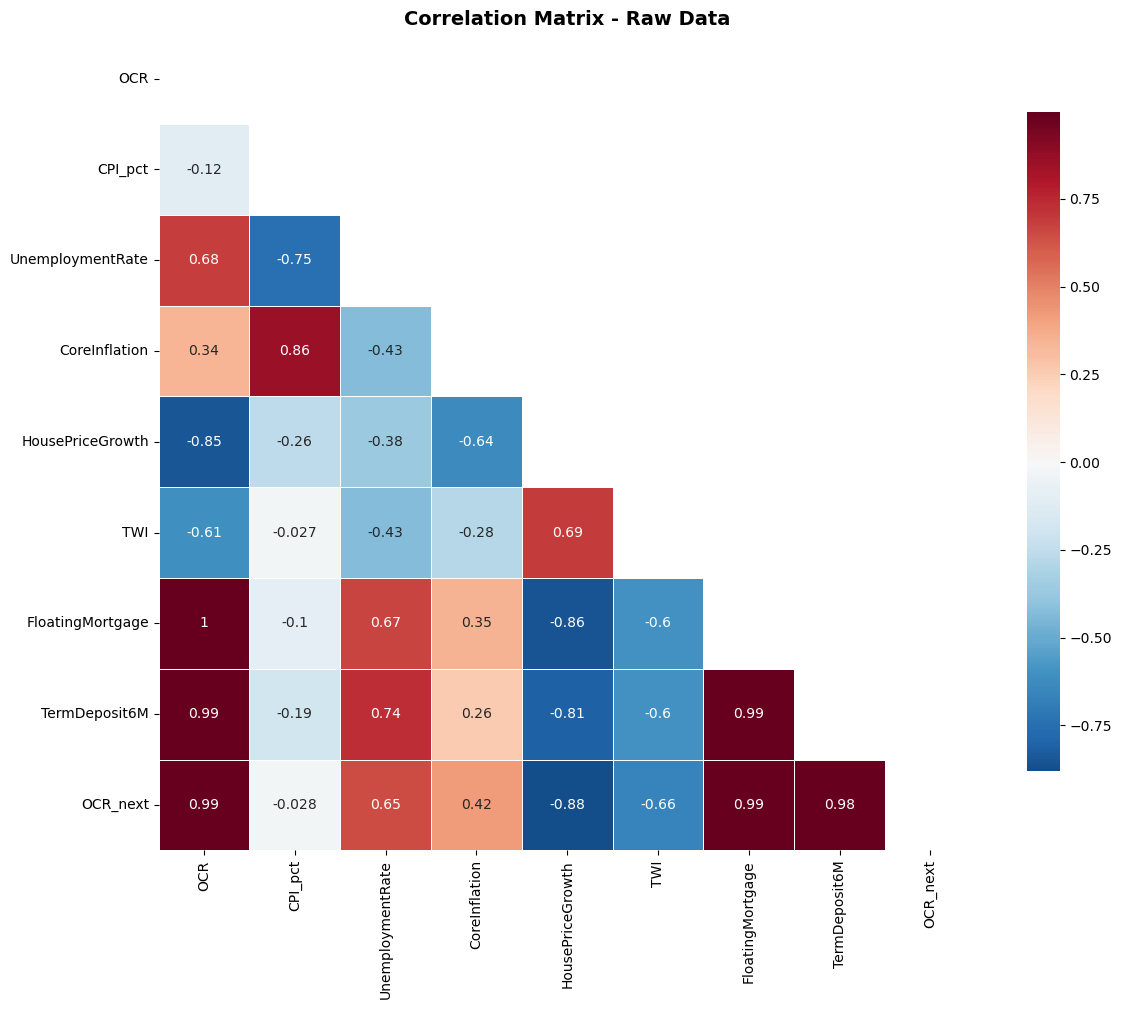

In [68]:
print(f"\nCorrelation Analysis (Pre-processing):")
numeric_cols = data_raw.select_dtypes(include=[np.number]).columns
correlation_matrix = data_raw[numeric_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Raw Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('02_raw_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
# Data Preprocessing and Feature Engineering
print(f"\nData Preprocessing and Feature Engineering")


# Create a copy for processing
data = data_raw.copy()

print("Creating lag features and technical indicators...")
# Lag features
data['OCR_lag1'] = data['OCR'].shift(1)
data['OCR_lag2'] = data['OCR'].shift(2)

# Change features
data['CPI_change'] = data['CPI_pct'].diff()
data['Unemployment_change'] = data['UnemploymentRate'].diff()
data['TWI_change'] = data['TWI'].diff()

# Moving averages (momentum indicators)
data['CPI_3ma'] = data['CPI_pct'].rolling(3).mean()
data['HousePrice_3ma'] = data['HousePriceGrowth'].rolling(3).mean()
data['Unemployment_3ma'] = data['UnemploymentRate'].rolling(3).mean()

# Interest rate spreads
data['Mortgage_OCR_spread'] = data['FloatingMortgage'] - data['OCR']
data['Deposit_OCR_spread'] = data['TermDeposit6M'] - data['OCR']

# Volatility measures
data['CPI_volatility'] = data['CPI_pct'].rolling(6).std()
data['OCR_volatility'] = data['OCR'].rolling(6).std()

print("Creating target variables...")
# Target variables
data['OCR_next'] = data['OCR'].shift(-1)  # Next month's OCR
data['OCR_direction'] = data.apply(lambda row: 
    'up' if row['OCR_next'] > row['OCR'] else 
    ('down' if row['OCR_next'] < row['OCR'] else 'same'), axis=1)

# Policy regime indicators
data['High_Inflation'] = (data['CPI_pct'] > 3.0).astype(int)  # Above RBNZ target
data['High_Unemployment'] = (data['UnemploymentRate'] > 5.0).astype(int)
data['Tightening_Cycle'] = (data['OCR'] > data['OCR_lag1']).astype(int)

print(f"Feature engineering complete. New shape: {data.shape}")



Data Preprocessing and Feature Engineering
Creating lag features and technical indicators...
Creating target variables...
Feature engineering complete. New shape: (44, 26)


In [70]:
# Post-Processing Data Quality
print(f"\nPost-Processing Data Quality")

# Remove rows with missing values
print(f"Original data: {len(data)} rows")
model_data = data.dropna()
print(f"After removing NAs: {len(model_data)} rows")
print(f"Data loss: {((len(data) - len(model_data)) / len(data) * 100):.1f}%")

# Feature list
feature_cols = ['OCR', 'OCR_lag1', 'OCR_lag2', 'CPI_pct', 'CPI_change', 'CPI_3ma', 'CPI_volatility',
                'UnemploymentRate', 'Unemployment_change', 'Unemployment_3ma', 'CoreInflation',
                'HousePriceGrowth', 'HousePrice_3ma', 'TWI', 'TWI_change', 
                'FloatingMortgage', 'TermDeposit6M', 'Mortgage_OCR_spread', 'Deposit_OCR_spread',
                'High_Inflation', 'High_Unemployment', 'Tightening_Cycle']

print(f"Final feature set: {len(feature_cols)} variables")



Post-Processing Data Quality
Original data: 44 rows
After removing NAs: 38 rows
Data loss: 13.6%
Final feature set: 22 variables



Post_Processing EDA visualizations


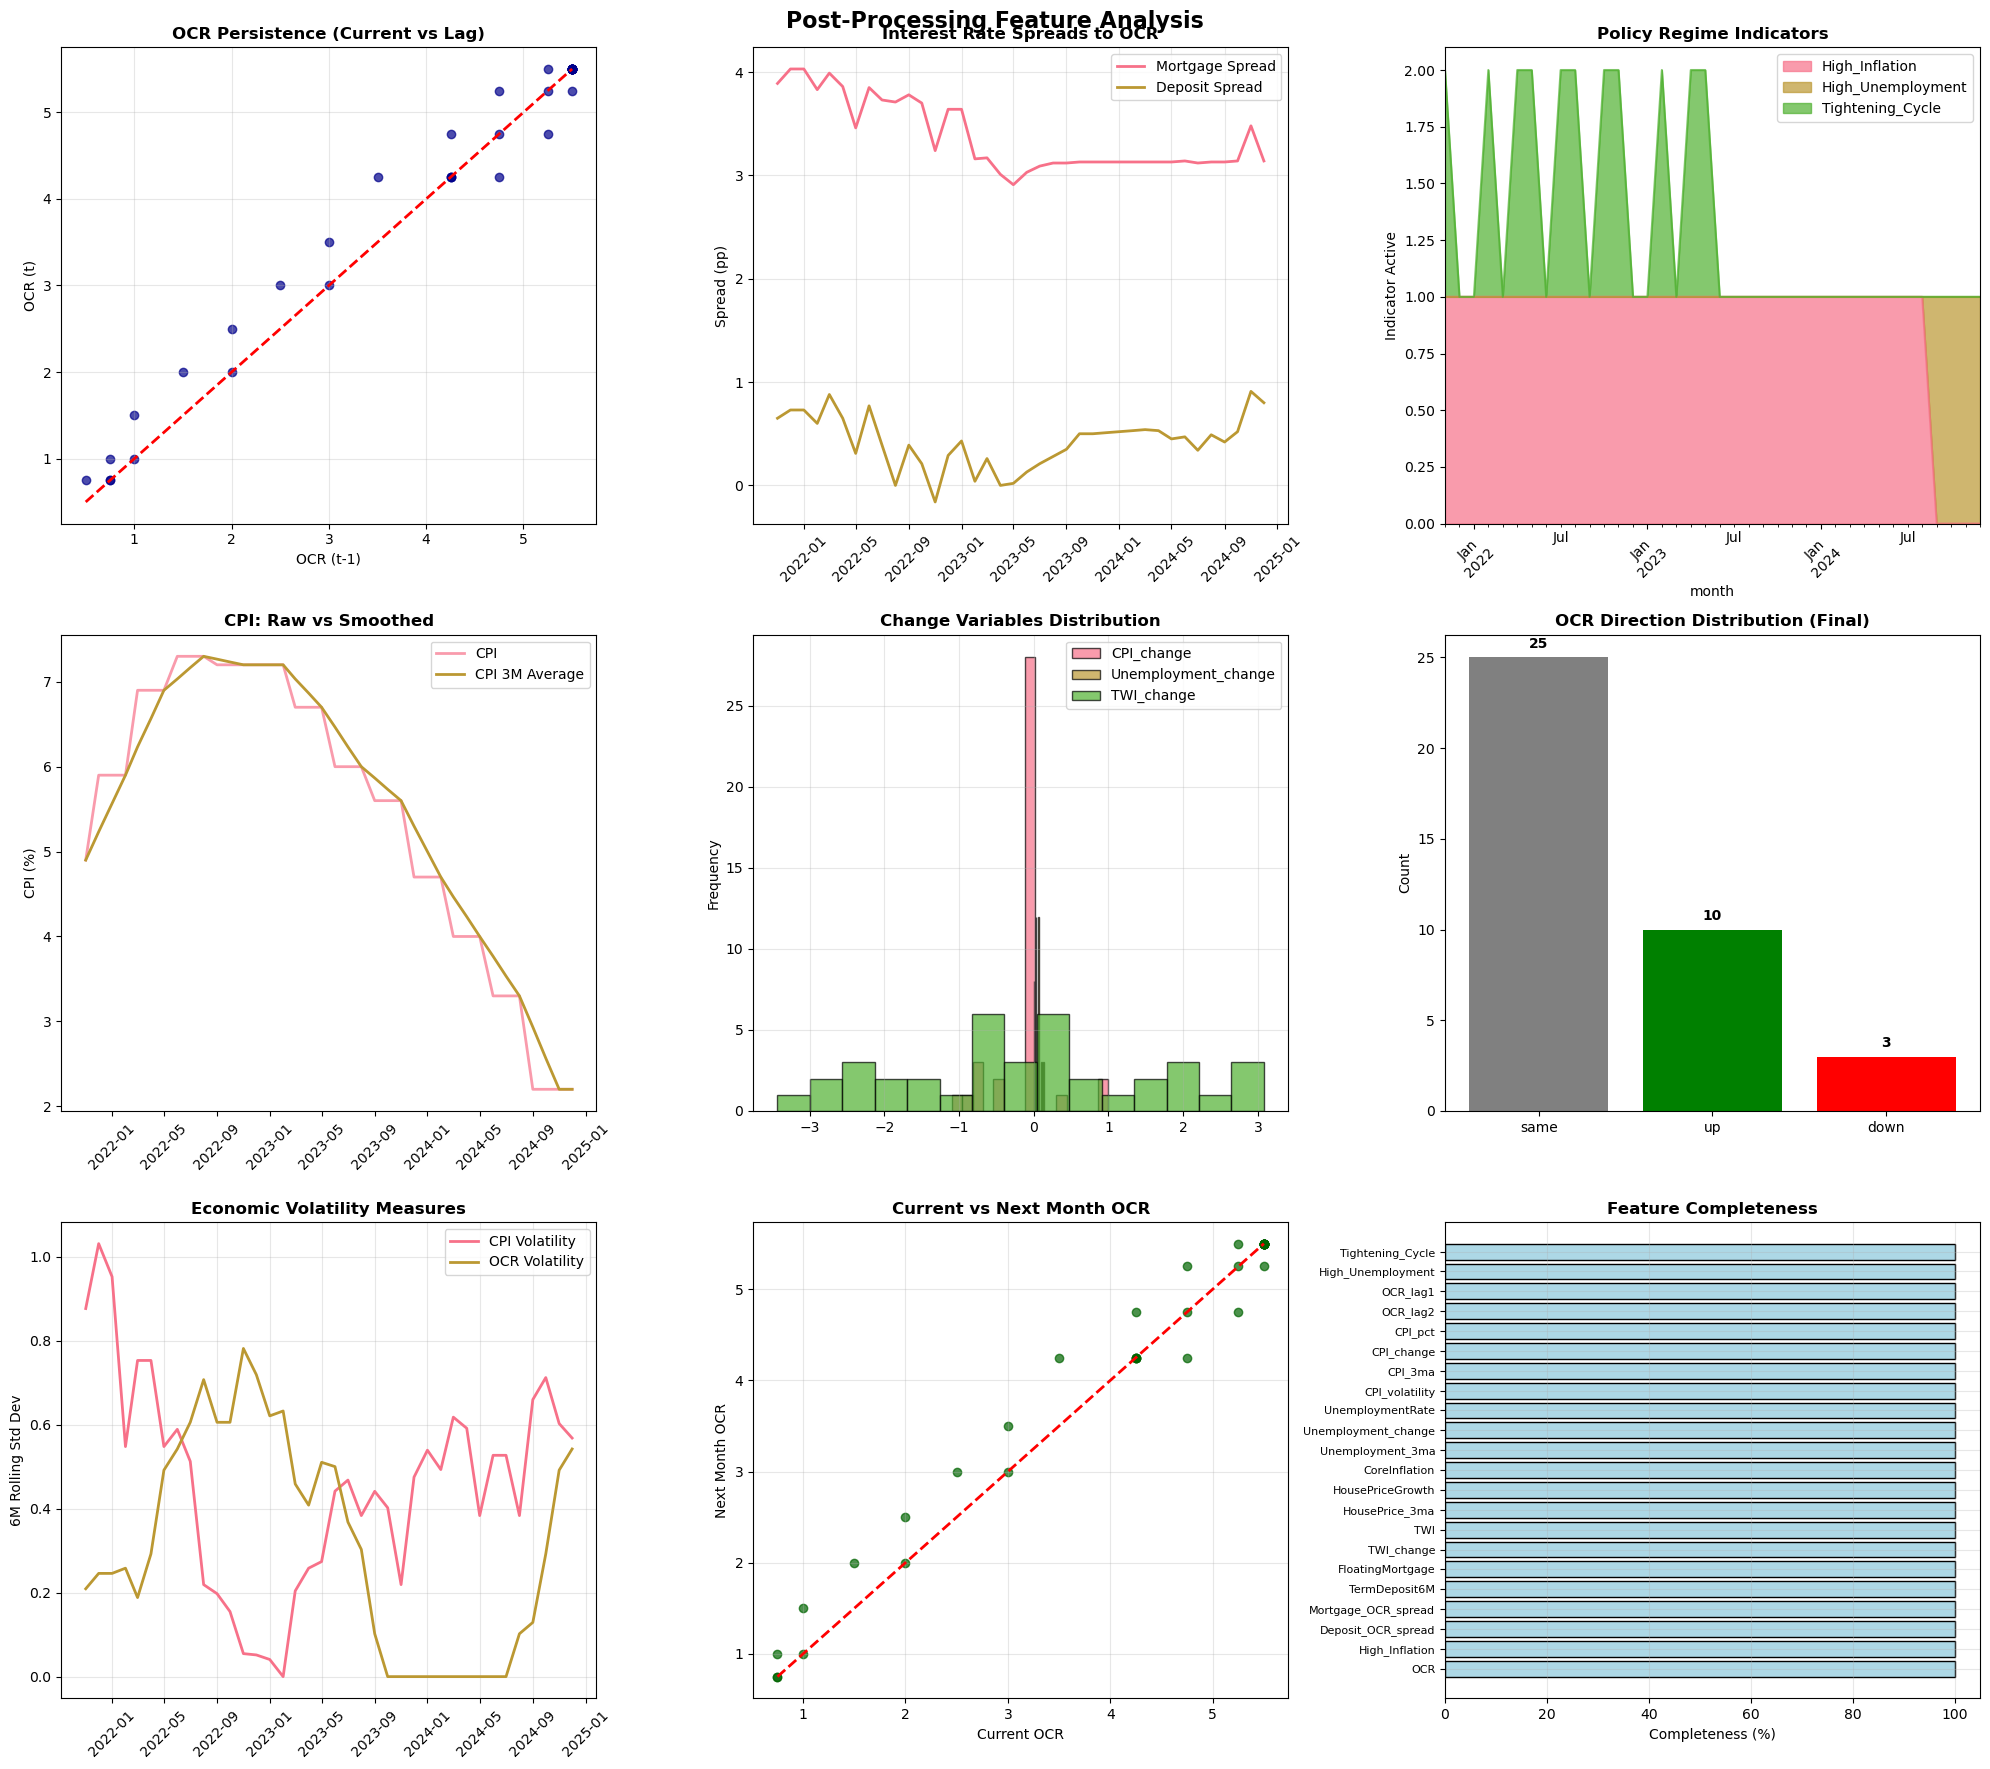

In [71]:
# Post_Processing EDA visualizations
print(f"\nPost_Processing EDA visualizations")
# Enhanced EDA after feature engineering
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Post-Processing Feature Analysis', fontsize=16, fontweight='bold')

# Plot 1: OCR vs OCR_lag1 (Persistence check)
axes[0,0].scatter(model_data['OCR_lag1'], model_data['OCR'], alpha=0.7, color='darkblue')
axes[0,0].plot([model_data['OCR_lag1'].min(), model_data['OCR_lag1'].max()], 
               [model_data['OCR_lag1'].min(), model_data['OCR_lag1'].max()], 'r--', lw=2)
axes[0,0].set_xlabel('OCR (t-1)')
axes[0,0].set_ylabel('OCR (t)')
axes[0,0].set_title('OCR Persistence (Current vs Lag)', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Interest Rate Spreads
axes[0,1].plot(model_data['month'], model_data['Mortgage_OCR_spread'], linewidth=2, label='Mortgage Spread')
axes[0,1].plot(model_data['month'], model_data['Deposit_OCR_spread'], linewidth=2, label='Deposit Spread')
axes[0,1].set_title('Interest Rate Spreads to OCR', fontweight='bold')
axes[0,1].set_ylabel('Spread (pp)')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Policy Regime Indicators
regime_data = model_data[['month', 'High_Inflation', 'High_Unemployment', 'Tightening_Cycle']].set_index('month')
regime_data.plot(kind='area', stacked=True, ax=axes[0,2], alpha=0.7)
axes[0,2].set_title('Policy Regime Indicators', fontweight='bold')
axes[0,2].set_ylabel('Indicator Active')
axes[0,2].tick_params(axis='x', rotation=45)

# Plot 4: CPI vs CPI Moving Average
axes[1,0].plot(model_data['month'], model_data['CPI_pct'], linewidth=2, label='CPI', alpha=0.7)
axes[1,0].plot(model_data['month'], model_data['CPI_3ma'], linewidth=2, label='CPI 3M Average')
axes[1,0].set_title('CPI: Raw vs Smoothed', fontweight='bold')
axes[1,0].set_ylabel('CPI (%)')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 5: Feature Distributions (Key variables)
key_features = ['CPI_change', 'Unemployment_change', 'TWI_change']
for i, feature in enumerate(key_features):
    if i < 3:
        row, col = 1, 1
        axes[row,col].hist(model_data[feature].dropna(), bins=15, alpha=0.7, 
                          label=feature, edgecolor='black')
        if i == 0:
            axes[row,col].set_title('Change Variables Distribution', fontweight='bold')
        axes[row,col].set_ylabel('Frequency')
        axes[row,col].legend()
        axes[row,col].grid(True, alpha=0.3)

# Plot 6: OCR Direction Distribution 
direction_counts = model_data['OCR_direction'].value_counts()
colors = ['red' if x == 'down' else 'gray' if x == 'same' else 'green' for x in direction_counts.index]
bars = axes[1,2].bar(direction_counts.index, direction_counts.values, color=colors)
axes[1,2].set_title('OCR Direction Distribution (Final)', fontweight='bold')
axes[1,2].set_ylabel('Count')
for bar, count in zip(bars, direction_counts.values):
    axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                   str(count), ha='center', fontweight='bold')

# Plot 7: Volatility Measures
axes[2,0].plot(model_data['month'], model_data['CPI_volatility'], linewidth=2, label='CPI Volatility')
axes[2,0].plot(model_data['month'], model_data['OCR_volatility'], linewidth=2, label='OCR Volatility')
axes[2,0].set_title('Economic Volatility Measures', fontweight='bold')
axes[2,0].set_ylabel('6M Rolling Std Dev')
axes[2,0].legend()
axes[2,0].tick_params(axis='x', rotation=45)
axes[2,0].grid(True, alpha=0.3)

# Plot 8: Target Variable (OCR_next) vs Current OCR
axes[2,1].scatter(model_data['OCR'], model_data['OCR_next'], alpha=0.7, color='darkgreen')
axes[2,1].plot([model_data['OCR'].min(), model_data['OCR'].max()], 
               [model_data['OCR'].min(), model_data['OCR'].max()], 'r--', lw=2)
axes[2,1].set_xlabel('Current OCR')
axes[2,1].set_ylabel('Next Month OCR')
axes[2,1].set_title('Current vs Next Month OCR', fontweight='bold')
axes[2,1].grid(True, alpha=0.3)

# Plot 9: Data Completeness by Variable
completeness = ((model_data[feature_cols].count() / len(model_data)) * 100).sort_values()
axes[2,2].barh(range(len(completeness)), completeness.values, color='lightblue', edgecolor='black')
axes[2,2].set_yticks(range(len(completeness)))
axes[2,2].set_yticklabels(completeness.index, fontsize=8)
axes[2,2].set_xlabel('Completeness (%)')
axes[2,2].set_title('Feature Completeness', fontweight='bold')
axes[2,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_processed_data_eda.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpreting visualisations**

We can see from the direction distribution that we are dealing with imbalanced classes, considering our small sample size we may have some issues modelling certain trends if we don't account for this in our model. 


Correlation Analysis (Post-processing):


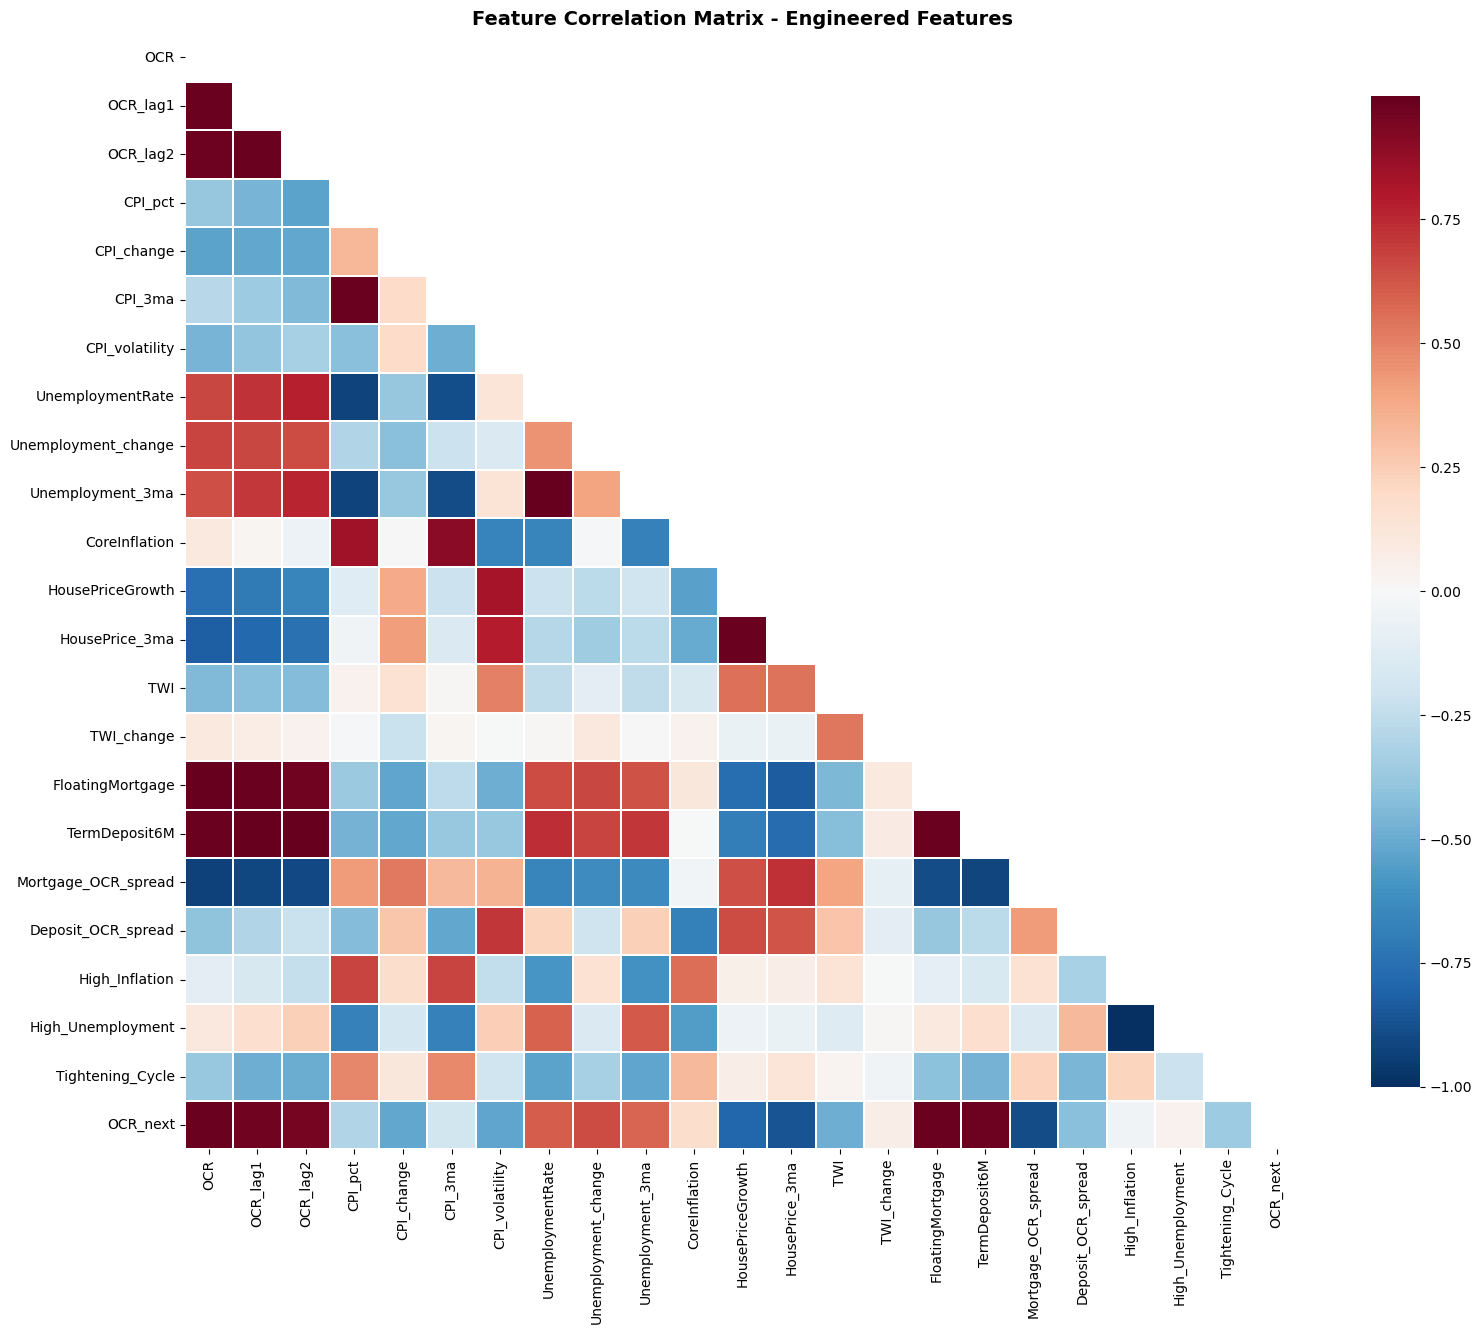

In [72]:
#Correlation matrix
print(f"\nCorrelation Analysis (Post-processing):")
feature_correlation = model_data[feature_cols + ['OCR_next']].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(feature_correlation, dtype=bool))
sns.heatmap(feature_correlation, mask=mask, annot=False, cmap='RdBu_r', center=0,
            square=True, linewidths=0.1, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix - Engineered Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('04_feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [73]:
# 6. Dataset Preparation for Modelling

print(f"\nDataset Preparation for Modelling")

X = model_data[feature_cols]
y_direction = model_data['OCR_direction']  # Classification target
y_rate = model_data['OCR_next']           # Regression target

# Split data (80/20 split)
X_train, X_test, y_dir_train, y_dir_test, y_rate_train, y_rate_test = train_test_split(
    X, y_direction, y_rate, test_size=0.2, random_state=42, stratify=y_direction
)


Dataset Preparation for Modelling


In [74]:
# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train)} observations")
print(f"Test set: {len(X_test)} observations")
print(f"Features: {len(feature_cols)} variables")
print(f"Direction distribution: {dict(y_direction.value_counts())}")


Training set: 30 observations
Test set: 8 observations
Features: 22 variables
Direction distribution: {'same': 25, 'up': 10, 'down': 3}


In [75]:
# Classification Model (Policy Direction Prediction)
print(f"\nBuilding Classification Model (Policy Direction)")

# Train multiple classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

classification_results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name == 'Logistic Regression':
        clf.fit(X_train_scaled, y_dir_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_dir_train)
        y_pred = clf.predict(X_test)
    
    # Evaluate
    accuracy = accuracy_score(y_dir_test, y_pred)
    
    print(f"{name} Accuracy: {accuracy:.3f}")
    print(f"Classification Report:\n{classification_report(y_dir_test, y_pred)}")
    
    classification_results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'predictions': y_pred
    }



Building Classification Model (Policy Direction)

Training Random Forest...
Random Forest Accuracy: 0.500
Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00         1
        same       0.60      0.60      0.60         5
          up       0.33      0.50      0.40         2

    accuracy                           0.50         8
   macro avg       0.31      0.37      0.33         8
weighted avg       0.46      0.50      0.47         8


Training Logistic Regression...
Logistic Regression Accuracy: 0.500
Classification Report:
              precision    recall  f1-score   support

        down       1.00      1.00      1.00         1
        same       0.60      0.60      0.60         5
          up       0.00      0.00      0.00         2

    accuracy                           0.50         8
   macro avg       0.53      0.53      0.53         8
weighted avg       0.50      0.50      0.50         8



In [76]:
# Regression Model (Exact Rate Prediction)
print(f"\nBuilding Regression Model (Exact OCR Rate)")

# Train multiple regressors
regressors = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

regression_results = {}

for name, reg in regressors.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name == 'Linear Regression':
        reg.fit(X_train_scaled, y_rate_train)
        y_pred = reg.predict(X_test_scaled)
    else:
        reg.fit(X_train, y_rate_train)
        y_pred = reg.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_rate_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_rate_test, y_pred)
    r2 = r2_score(y_rate_test, y_pred)
    
    print(f"{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    
    regression_results[name] = {
        'model': reg,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }



Building Regression Model (Exact OCR Rate)

Training Random Forest...
Random Forest Performance:
  RMSE: 0.2736
  MAE: 0.1966
  R²: 0.9626

Training Linear Regression...
Linear Regression Performance:
  RMSE: 0.1886
  MAE: 0.1582
  R²: 0.9822


In [77]:
# Analysis of Feature Importance

print(f"\nFeature Importance Analysis")

# Get feature importance from Random Forest models
rf_clf = classification_results['Random Forest']['model']
rf_reg = regression_results['Random Forest']['model']

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Classification_Importance': rf_clf.feature_importances_,
    'Regression_Importance': rf_reg.feature_importances_
})

feature_importance = feature_importance.sort_values('Classification_Importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Feature Importance Analysis

Top 10 Most Important Features:
                Feature  Classification_Importance  Regression_Importance
5               CPI_3ma                   0.130849               0.007797
18   Deposit_OCR_spread                   0.086697               0.000659
3               CPI_pct                   0.074427               0.009377
7      UnemploymentRate                   0.069016               0.125523
17  Mortgage_OCR_spread                   0.066775               0.014388
11     HousePriceGrowth                   0.063691               0.018601
13                  TWI                   0.057084               0.001885
10        CoreInflation                   0.056673               0.009208
1              OCR_lag1                   0.054939               0.107543
9      Unemployment_3ma                   0.052209               0.111682



Model Performance Visualisations


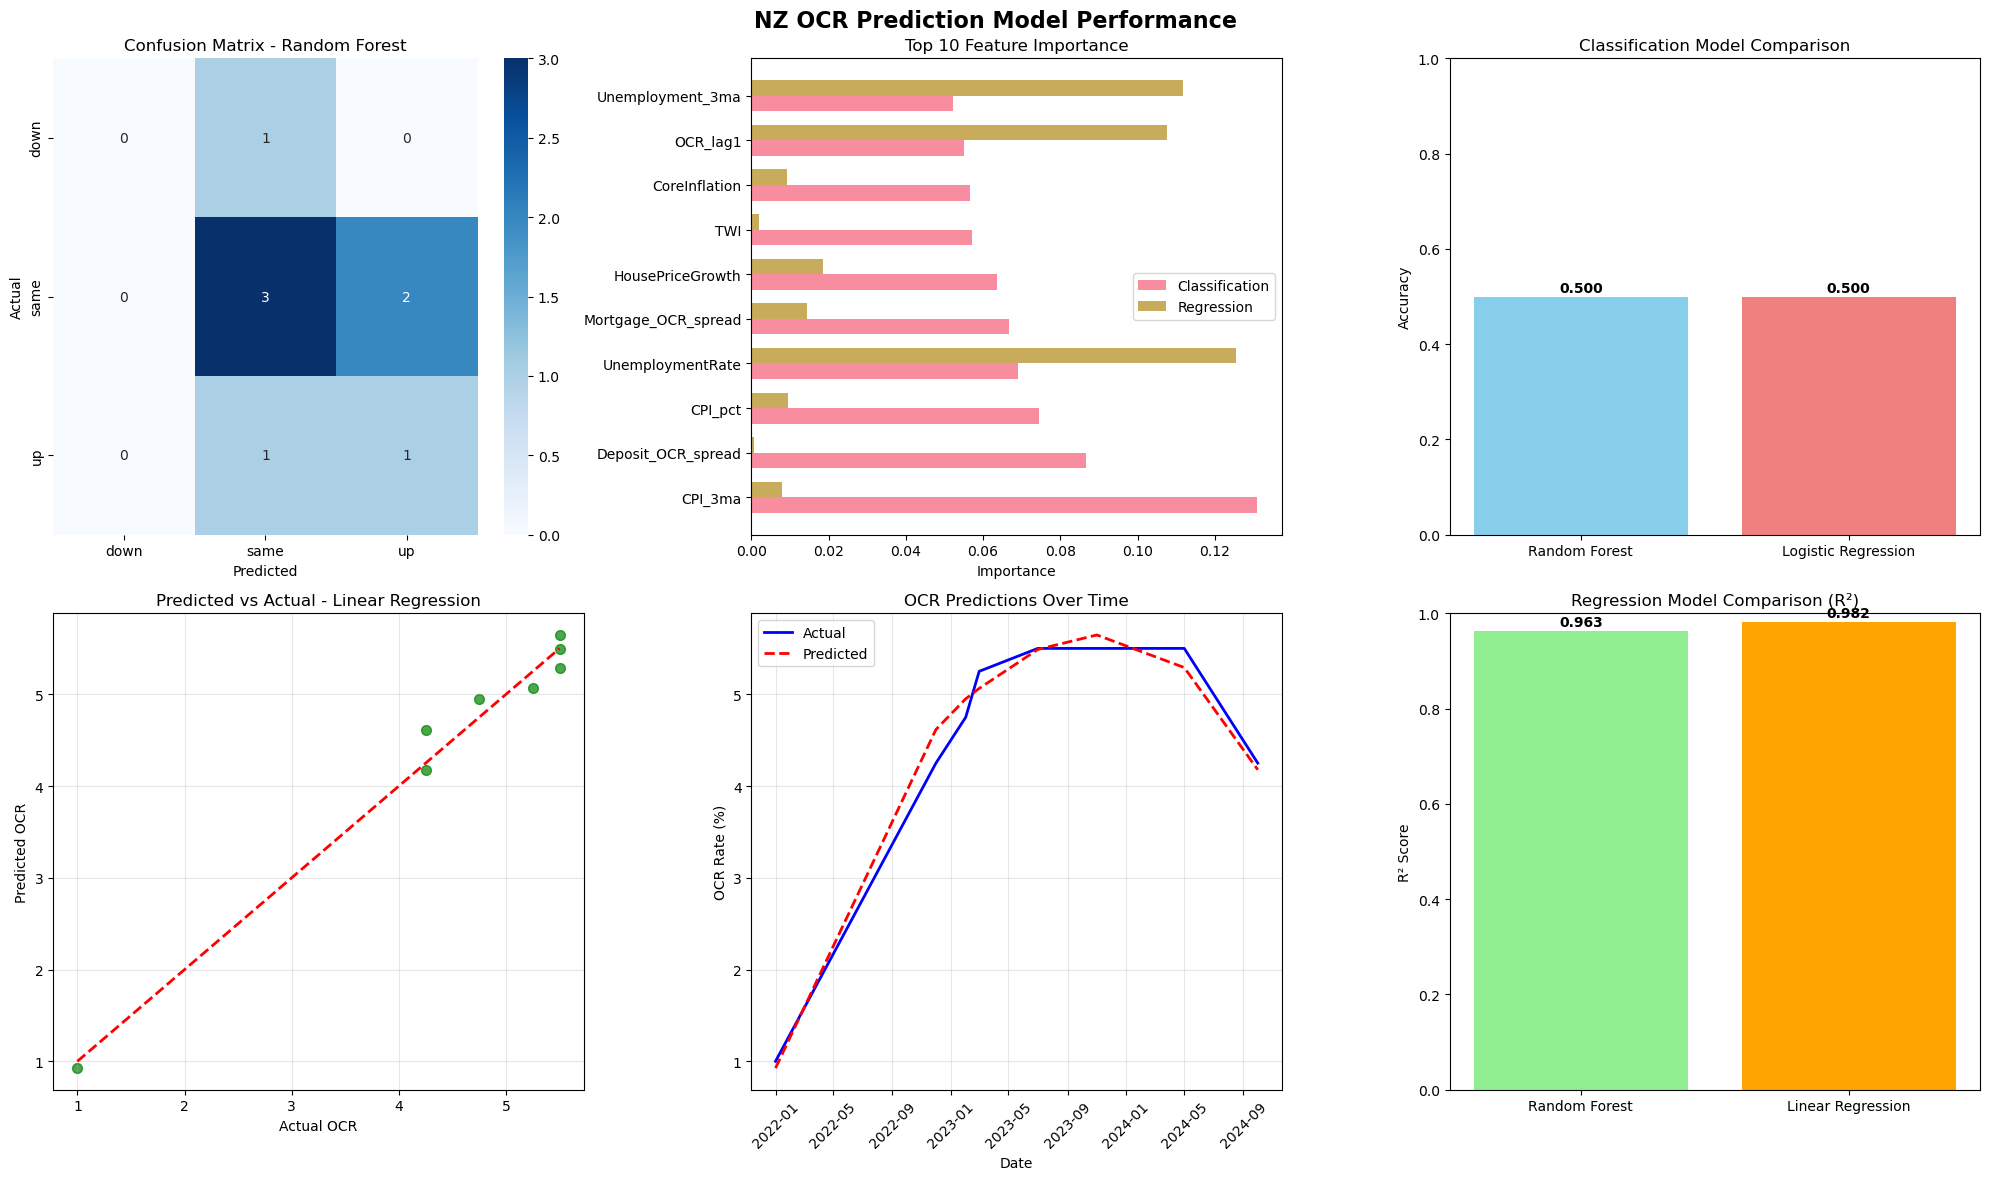

In [78]:

# Visualisations of Model Performance

print(f"\nModel Performance Visualisations")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('NZ OCR Prediction Model Performance', fontsize=16, fontweight='bold')

# Plot 1: Confusion Matrix for Best Classification Model
best_clf_name = max(classification_results.keys(), 
                   key=lambda x: classification_results[x]['accuracy'])
best_clf_pred = classification_results[best_clf_name]['predictions']

cm = confusion_matrix(y_dir_test, best_clf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['down', 'same', 'up'], 
            yticklabels=['down', 'same', 'up'], ax=axes[0,0])
axes[0,0].set_title(f'Confusion Matrix - {best_clf_name}')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# Plot 2: Feature Importance Comparison
top_features = feature_importance.head(10)
x_pos = np.arange(len(top_features))
width = 0.35

axes[0,1].barh(x_pos - width/2, top_features['Classification_Importance'], width, 
               label='Classification', alpha=0.8)
axes[0,1].barh(x_pos + width/2, top_features['Regression_Importance'], width, 
               label='Regression', alpha=0.8)
axes[0,1].set_yticks(x_pos)
axes[0,1].set_yticklabels(top_features['Feature'], fontsize=10)
axes[0,1].set_xlabel('Importance')
axes[0,1].set_title('Top 10 Feature Importance')
axes[0,1].legend()

# Plot 3: Model Accuracy Comparison
clf_names = list(classification_results.keys())
clf_accuracies = [classification_results[name]['accuracy'] for name in clf_names]
bars = axes[0,2].bar(clf_names, clf_accuracies, color=['skyblue', 'lightcoral'])
axes[0,2].set_title('Classification Model Comparison')
axes[0,2].set_ylabel('Accuracy')
axes[0,2].set_ylim(0, 1)
for bar, acc in zip(bars, clf_accuracies):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{acc:.3f}', ha='center', fontweight='bold')

# Plot 4: Regression Predictions vs Actual
best_reg_name = max(regression_results.keys(), 
                   key=lambda x: regression_results[x]['r2'])
best_reg_pred = regression_results[best_reg_name]['predictions']

axes[1,0].scatter(y_rate_test, best_reg_pred, alpha=0.7, color='green', s=50)
axes[1,0].plot([y_rate_test.min(), y_rate_test.max()], 
               [y_rate_test.min(), y_rate_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual OCR')
axes[1,0].set_ylabel('Predicted OCR')
axes[1,0].set_title(f'Predicted vs Actual - {best_reg_name}')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Time Series of Predictions
test_dates = model_data.loc[X_test.index, 'month']
prediction_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_rate_test.values,
    'Predicted': best_reg_pred
}).sort_values('Date')

axes[1,1].plot(prediction_df['Date'], prediction_df['Actual'], 'b-', label='Actual', linewidth=2)
axes[1,1].plot(prediction_df['Date'], prediction_df['Predicted'], 'r--', label='Predicted', linewidth=2)
axes[1,1].set_title('OCR Predictions Over Time')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('OCR Rate (%)')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Plot 6: Regression Model Comparison
reg_names = list(regression_results.keys())
reg_r2 = [regression_results[name]['r2'] for name in reg_names]
bars = axes[1,2].bar(reg_names, reg_r2, color=['lightgreen', 'orange'])
axes[1,2].set_title('Regression Model Comparison (R²)')
axes[1,2].set_ylabel('R² Score')
axes[1,2].set_ylim(0, 1)
for bar, r2 in zip(bars, reg_r2):
    axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{r2:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('05_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [79]:
print(f"\nPipeline Summary:")
print(f"  • Raw data: {data_raw.shape[0]} observations, {data_raw.shape[1]} variables")
print(f"  • Post-processing: {len(model_data)} observations, {len(feature_cols)} features")
print(f"  • Data coverage: {model_data['month'].min().strftime('%Y-%m')} to {model_data['month'].max().strftime('%Y-%m')}")
print(f"  • Missing data handled: {((len(data_raw) - len(model_data)) / len(data_raw) * 100):.1f}% data loss")


Pipeline Summary:
  • Raw data: 44 observations, 11 variables
  • Post-processing: 38 observations, 22 features
  • Data coverage: 2021-11 to 2024-12
  • Missing data handled: 13.6% data loss


In [80]:
print(f"\nClassification Model Results:")
for name, results in classification_results.items():
    print(f"  • {name}: {results['accuracy']:.1%} accuracy")


Classification Model Results:
  • Random Forest: 50.0% accuracy
  • Logistic Regression: 50.0% accuracy


In [81]:
print(f"\nRegression Model Results:")
for name, results in regression_results.items():
    print(f"  • {name}: R² = {results['r2']:.3f}, RMSE = {results['rmse']:.4f}")


Regression Model Results:
  • Random Forest: R² = 0.963, RMSE = 0.2736
  • Linear Regression: R² = 0.982, RMSE = 0.1886


**Model Evaluation**

The Regression model achieved great performance, it predicted the exact OCR rate with RMSE = 0.1886 whilst accounting for 98% of the variance in the data. This performance was surprisingly achieved by the much simpler linear regression model than the RandomForest ensemble model. The classification model struggled greatly, achieving no better than random prediction results (50% classification accuracy). This may be caused by the lack of model optimisation towards a smaller dataset with a small pool of test observations. To better drive policy decisions, it's necessary to implement a model more robust to imbalanced classes and use different algorithms that work better with the provided data.

In [83]:
# Additional Ensemble Methods
print(f"\n12. ADVANCED ENSEMBLE METHODS ANALYSIS")
print("="*50)

# Import additional ensemble libraries
try:
    from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, 
                                 VotingClassifier, StackingClassifier)
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    
    # Try to import imbalanced-learn libraries
    try:
        from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
        from imblearn.over_sampling import SMOTE
        from imblearn.pipeline import Pipeline as ImbPipeline
        imbalanced_available = True
        print("Imbalanced-learn library available - using class-imbalance methods")
    except ImportError:
        imbalanced_available = False
        print("Imbalanced-learn not available - skipping SMOTE methods")
        print("Install with: pip install imbalanced-learn")
    
    ensemble_results = {}
    
    print("\nNote: Your Random Forest already uses bootstrap aggregation (bagging)")
    print("Implementing more ensemble methods...")
    
    print("\n Boosting Algorithms (Sequential Learning)")
    print("-" * 50)
    
    boosting_models = {
        'AdaBoost': AdaBoostClassifier(
            n_estimators=50, 
            learning_rate=0.8,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
    }
    
    for name, model in boosting_models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_dir_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_dir_test, y_pred)
        
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Classification Report:\n{classification_report(y_dir_test, y_pred, zero_division=0)}")
        
        ensemble_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'type': 'Boosting'
        }
    
    print("\nVoting Classifiers (Heterogeneous Ensembles)")
    print("-" * 50)
    
    # Different base learners for voting
    base_classifiers = [
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('nb', GaussianNB()),
        ('knn', KNeighborsClassifier(n_neighbors=3))
    ]
    
    voting_models = {
        'Hard Voting': VotingClassifier(
            estimators=base_classifiers,
            voting='hard'
        ),
        'Soft Voting': VotingClassifier(
            estimators=base_classifiers,
            voting='soft'
        )
    }
    
    for name, model in voting_models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_scaled, y_dir_train)  
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_dir_test, y_pred)
        
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Classification Report:\n{classification_report(y_dir_test, y_pred, zero_division=0)}")
        
        ensemble_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'type': 'Voting'
        }
    
    print("\nStacking Classifier (Meta-Learning)")
    print("-" * 50)
    
    # Stacking with meta-learner
    stacking_model = StackingClassifier(
        estimators=base_classifiers,
        final_estimator=LogisticRegression(random_state=42),
        cv=3  # Use 3-fold CV due to small dataset
    )
    
    print("\nTraining Stacking Classifier...")
    stacking_model.fit(X_train_scaled, y_dir_train)
    y_pred = stacking_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_dir_test, y_pred)
    
    print(f"  Accuracy: {accuracy:.3f}")
    print(f"  Classification Report:\n{classification_report(y_dir_test, y_pred, zero_division=0)}")
    
    ensemble_results['Stacking'] = {
        'model': stacking_model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'type': 'Stacking'
    }
    
    # Class-imbalance aware methods
    if imbalanced_available:
        print("\nClass Imbalance aware methods")
        print("-" * 50)
        
        imbalanced_models = {
            'Balanced Random Forest': BalancedRandomForestClassifier(
                n_estimators=50,
                random_state=42
            ),
            'Balanced Bagging': BalancedBaggingClassifier(
                n_estimators=50,
                random_state=42
            )
        }
        
        for name, model in imbalanced_models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train, y_dir_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_dir_test, y_pred)
            
            print(f"  Accuracy: {accuracy:.3f}")
            print(f"  Classification Report:\n{classification_report(y_dir_test, y_pred, zero_division=0)}")
            
            ensemble_results[name] = {
                'model': model,
                'accuracy': accuracy,
                'predictions': y_pred,
                'type': 'Imbalanced-Aware'
            }
        
        print("\nSMOTE + Ensemble techniques")
        print("-" * 50)
        
        # SMOTE preprocessing + ensemble
        smote_models = {
            'SMOTE + Random Forest': ImbPipeline([
                ('smote', SMOTE(random_state=42, k_neighbors=2)),  # k_neighbors=2 for small dataset
                ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
            ]),
            'SMOTE + Gradient Boosting': ImbPipeline([
                ('smote', SMOTE(random_state=42, k_neighbors=2)),
                ('classifier', GradientBoostingClassifier(n_estimators=30, random_state=42))
            ])
        }
        
        for name, pipeline in smote_models.items():
            print(f"\nTraining {name}...")
            try:
                pipeline.fit(X_train, y_dir_train)
                y_pred = pipeline.predict(X_test)
                accuracy = accuracy_score(y_dir_test, y_pred)
                
                print(f"  Accuracy: {accuracy:.3f}")
                print(f"  Classification Report:\n{classification_report(y_dir_test, y_pred, zero_division=0)}")
                
                ensemble_results[name] = {
                    'model': pipeline,
                    'accuracy': accuracy,
                    'predictions': y_pred,
                    'type': 'SMOTE+Ensemble'
                }
            except Exception as e:
                print(f"  Failed: {str(e)}")
    
    #Ensemble Results
    print(f"\nEnsemble Analysis")
    print("="*50)
    
    # Add original results for comparison
    ensemble_results['Original Random Forest'] = {
        'model': classification_results['Random Forest']['model'],
        'accuracy': classification_results['Random Forest']['accuracy'],
        'predictions': classification_results['Random Forest']['predictions'],
        'type': 'Baseline (Bagging)'
    }
    
    ensemble_results['Original Logistic Regression'] = {
        'model': classification_results['Logistic Regression']['model'],
        'accuracy': classification_results['Logistic Regression']['accuracy'],
        'predictions': classification_results['Logistic Regression']['predictions'],
        'type': 'Baseline'
    }
    
    # Find best model
    best_ensemble_name = max(ensemble_results.keys(), key=lambda x: ensemble_results[x]['accuracy'])
    best_ensemble_accuracy = ensemble_results[best_ensemble_name]['accuracy']
    
    print(f"\nBest Ensemble Method: {best_ensemble_name}")
    print(f"Best Accuracy: {best_ensemble_accuracy:.3f}")
    
    # Results by category
    print(f"\nResults by Category:")
    print("-" * 40)
    
    categories = {}
    for name, result in ensemble_results.items():
        category = result.get('type', 'Other')
        if category not in categories:
            categories[category] = []
        categories[category].append((name, result['accuracy']))
    
    for category, models in categories.items():
        print(f"\n{category}:")
        models.sort(key=lambda x: x[1], reverse=True)  # Sort by accuracy
        for model_name, accuracy in models:
            print(f"  {model_name}: {accuracy:.3f}")
    
    # Improvement analysis
    original_rf_acc = classification_results['Random Forest']['accuracy']
    original_lr_acc = classification_results['Logistic Regression']['accuracy']
    
    improvement_rf = best_ensemble_accuracy - original_rf_acc
    improvement_lr = best_ensemble_accuracy - original_lr_acc
    
    print(f"\nImprovement Analysis:")
    print("-" * 30)
    print(f"Original Random Forest: {original_rf_acc:.3f}")
    print(f"Original Logistic Regression: {original_lr_acc:.3f}")
    print(f"Best Ensemble: {best_ensemble_accuracy:.3f}")
    print(f"Improvement over RF: {improvement_rf:+.3f}")
    print(f"Improvement over LR: {improvement_lr:+.3f}")
    
    # Top 3 models
    top_models = sorted(ensemble_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:5]
    print(f"\nTop 5 Models:")
    for i, (name, result) in enumerate(top_models, 1):
        print(f"  {i}. {name}: {result['accuracy']:.3f} ({result['type']})")
    
    # Detailed analysis of best model
    print(f"\nAnalysis - {best_ensemble_name}:")
    print("-" * 50)
    best_predictions = ensemble_results[best_ensemble_name]['predictions']
    print(f"Confusion Matrix:")
    cm = confusion_matrix(y_dir_test, best_predictions)
    print(f"              Predicted")
    print(f"        down  same   up")
    print(f"down     {cm[0,0]:2d}    {cm[0,1]:2d}   {cm[0,2]:2d}")
    print(f"same     {cm[1,0]:2d}    {cm[1,1]:2d}   {cm[1,2]:2d}")  
    print(f"up       {cm[2,0]:2d}    {cm[2,1]:2d}   {cm[2,2]:2d}")


except ImportError:
    print("Advanced ensemble libraries not available.")
    print("Install with: pip install scikit-learn>=1.0")
    print("For imbalanced data methods: pip install imbalanced-learn")



12. ADVANCED ENSEMBLE METHODS ANALYSIS
Imbalanced-learn library available - using class-imbalance methods

Note: Your Random Forest already uses bootstrap aggregation (bagging)
Implementing more ensemble methods...

 Boosting Algorithms (Sequential Learning)
--------------------------------------------------

Training AdaBoost...
  Accuracy: 0.500
  Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00         1
        same       0.60      0.60      0.60         5
          up       0.33      0.50      0.40         2

    accuracy                           0.50         8
   macro avg       0.31      0.37      0.33         8
weighted avg       0.46      0.50      0.47         8


Training Gradient Boosting...
  Accuracy: 0.500
  Classification Report:
              precision    recall  f1-score   support

        down       0.00      0.00      0.00         1
        same       0.60      0.60      0.60         5
      

**Final Model Evaluation**

The final data pipeline instead of the original ensemble RandomForest classifier, we will use the Balanced RandomForest Classifier which takes into account the imbalanced distribution of classes. Which achieved 75% accuracy compared to 50% from the previous model. This makes a useful policy-driving tool which enables us to better determine OCR move direction. Some considerations to take into account when applying these models are that this model was trained and tested on a small sample of data. To look at how truly well these models can capture the data, it may be worth applying to other countries macroeconomic data to see if results are reproducible in unseen data.